In [1]:
from __future__ import print_function

import os
import re
import nltk
import tarfile
from pathlib import Path
from time import time
from functools import reduce
from pprint import pprint
from typing import List, Tuple

import keras
import numpy as np
import pandas as pd

from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import recurrent, Input, Embedding, RepeatVector, Dropout, Dense, LSTM
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.data_utils import get_file
from tqdm import tqdm
from tensorflow.python.keras.models import Sequential
#by this option we disable the possibility of a bad dataframe representation
pd.set_option('display.expand_frame_repr', False)

In [2]:
#import the already preprocessed dataset 
sdg_df  = pd.read_csv('sdg_classification_data.csv')
sdg_df

,sdg,extracted_title,extracted_abstract,initial_text
0,SDG10,trade liberalization policies aligned renewabl...,paper attempts empirically analyze compatibili...,trade liberalization policies aligned renewabl...
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...
2,SDG10,energy consumption gdp revisited new panel app...,combines panel techniques wavelet spectral inv...,energy consumption gdp revisited new panel app...
3,SDG10,multiple perspective modeling simulation appro...,environmental issues dependence fossil fuel so...,multiple perspective modeling simulation appro...
4,SDG10,integrating blockchain technology energy secto...,blockchain technology ushering nothing short d...,integrating blockchain technology energy secto...
...,...,...,...,...
884,SDG7,africa sustainable energy goal focus access re...,sustainable development goal sdg focuses ensur...,africa sustainable energy goal focus access re...
885,SDG7,scalingup sustainable renewable energy generat...,three processes urbanization industrialization...,scalingup sustainable renewable energy generat...
886,SDG7,brief review application laser biotechnology e...,abstract bioenergy production biomass sources ...,brief review application laser biotechnology e...
887,SDG7,electric vehicles impacts integration power gr...,exponential rise electricity demand become pri...,electric vehicles impacts integration power gr...


In [3]:
#import the validation dataset given by Mr. Fergadis
validation_df = pd.read_csv('validation_dataset_v2.csv')
validation_df

,sdg,extracted_title,extracted_abstract,initial_text
0,SDG7,solid oxide fuel cell hybrid system detailed r...,paper reports review environmentally clean eff...,solid oxide fuel cell hybrid system detailed r...
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...
2,SDG10,comprehensive indicator set measuring multiple...,paper develop quantitative indicator approach ...,comprehensive indicator set measuring multiple...
3,SDG10,foreign direct investment renewable energy cli...,climate change mitigation topical issue growin...,foreign direct investment renewable energy cli...
4,SDG10,energy storage multi energy systems local ener...,investigates district high capacity noncontrol...,energy storage multi energy systems local ener...
...,...,...,...,...
94,SDG13,dual stresses flooding agricultural land reduc...,global climate change leading significant incr...,dual stresses flooding agricultural land reduc...
95,SDG13,trend extreme rainfall events suitable global ...,kolkata metropolitan area kma one densely popu...,trend extreme rainfall events suitable global ...
96,SDG13,grounding line ice frontal position coastal ic...,past years satellite remote sensing captured s...,grounding line ice frontal position coastal ic...
97,SDG13,environment stupid values motivations routes e...,exploratory mixedmethods indepth interviews in...,environment stupid values motivations routes e...


In [4]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
# The raw input (Title)
X = sdg_df['extracted_abstract']
X_val = validation_df['extracted_abstract']

X.head(10)

0    paper attempts empirically analyze compatibili...
1    aim determine nature relationship renewable en...
2    combines panel techniques wavelet spectral inv...
3    environmental issues dependence fossil fuel so...
4    blockchain technology ushering nothing short d...
5    paper estimates impact renewable energy econom...
6    increasing concerns environmental economic imp...
7    account continuously increasing electricity co...
8    paper aims analyze interaction renewable energ...
9    middle east north africa mena countries recent...
Name: extracted_abstract, dtype: object

In [6]:
# The raw output (lyricists)
y = sdg_df['sdg']
y_val = validation_df['sdg']

y.head(10)

0    SDG10
1    SDG10
2    SDG10
3    SDG10
4    SDG10
5    SDG10
6    SDG10
7    SDG10
8    SDG10
9    SDG10
Name: sdg, dtype: object

In [7]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [8]:
X_train, X_test, y_train, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in val_sss.split(X, y):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN-VAL: [235 643 578 605 356 284 587   4  79   1] TEST: [117 257 454 418 396 495   3 724 504  36]
TRAIN-VAL: [576 649  70 549 246 131 712 651 391 497] TEST: [431 823 454 861 168 691 332 658 386  72]
TRAIN-VAL: [551 283  24 235 794 434 594 624 188 835] TEST: [262 641 117 533  10 767 230 462 768 517]
TRAIN-VAL: [292 745 672 740  16 376 398 774 632 457] TEST: [198 720 644 440 293 599 693  22 799 625]
TRAIN-VAL: [ 53 433 231 437 190 762 362 761 169 530] TEST: [545 764 741 109 666 661 712 445 600 167]


In [9]:
# check here the indexes. 
X_train.head()

53     energy transitions aim economic prosperity gre...
433    objective research advance evaluation monetiza...
231    abstract satellite show increasing leaf area v...
437    purpose although quality life qol improves tim...
190    abstract per mille soils food security climate...
Name: extracted_abstract, dtype: object

In [10]:
y_train.head(10)

53     SDG12
433     SDG3
231    SDG13
437     SDG3
190    SDG13
762     SDG5
362     SDG3
761     SDG5
169    SDG13
530     SDG3
Name: sdg, dtype: object

In [11]:
# We reset the indexes for both the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [12]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (711,)
y_train shape: (711,)

X_val shape: (99,)
y_val shape: (99,)

X_test shape: (178,)
y_test shape: (178,)


In [13]:
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [14]:
# At first we run fit_transform on the Training data
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc


array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [15]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [16]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (711, 6)
y_val shape: (99, 6)
y_test shape: (178, 6)


In [17]:
# The categories that we obtained by the Encoder
y_enc.categories_

[array(['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'], dtype=object)]

In [18]:
# What the aforementioned code did:
temp = pd.DataFrame(y_train_enc)
temp.columns = list(y_enc.categories_[0])
temp.head(10)

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
def highlight_ones(s):
    '''
    highlight the number 1 in a Series yellow.
    '''
    is_max = s == 1
    return ['background-color: yellow' if v else '' for v in is_max]
temp.head(10).style.apply(highlight_ones)

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [20]:
temp.sum(axis=0).head(10)

SDG10     40.0
SDG12     35.0
SDG13    194.0
SDG3     211.0
SDG5     198.0
SDG7      33.0
dtype: float64

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [55]:
#define max_words parameter
max_words = 250

In [56]:
# Some parameters that we will use:

# Number of Classes for the Y labels (number of lyricists)
nb_classes = len(y_enc.categories_[0])

print('Number of Classes (SDG): {}'.format(nb_classes))

# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 10

# The batch_size of the data that will be fed to the Model when training
batch_size = 32 

# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.4

Number of Classes (SDG): 6


In [57]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs dropped
model.add(Dropout(0.4))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model.add(Dense(nb_classes))

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('softmax'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               128512    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None,

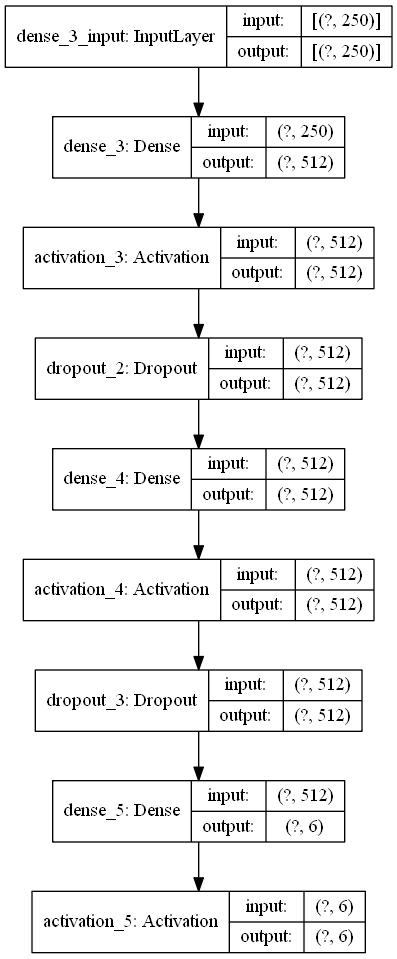

In [58]:
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [59]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [61]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=False # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(max_features=250, strip_accents='unicode')

In [62]:
X_train_enc = counter_vectorizer.fit_transform(X_train)

In [63]:
X_train_enc

<711x250 sparse matrix of type '<class 'numpy.int64'>'
	with 19990 stored elements in Compressed Sparse Row format>

In [64]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc = counter_vectorizer.transform(X_val)
X_test_enc = counter_vectorizer.transform(X_test)

In [65]:
print('X_train encoded shape: {}'.format(X_train_enc.shape))
print('X_val encoded shape: {}'.format(X_val_enc.shape))
print('X_test encoded shape: {}'.format(X_test_enc.shape))

X_train encoded shape: (711, 250)
X_val encoded shape: (99, 250)
X_test encoded shape: (178, 250)


In [66]:
X_train_enc[0].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 4, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int64)

In [67]:
X_train_enc.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 3, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [68]:
y_train_enc

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [69]:
X_val_enc.todense()

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [70]:
y_val_enc

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [71]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc.todense(), # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_test_enc.todense(),     # the validation split that we did before
    y_test_enc)
)

Epoch 1/10
23/23 - 0s - loss: 0.9987 - accuracy: 0.6737 - val_loss: 0.4837 - val_accuracy: 0.8596
Epoch 2/10
23/23 - 0s - loss: 0.3505 - accuracy: 0.8959 - val_loss: 0.3530 - val_accuracy: 0.8764
Epoch 3/10
23/23 - 0s - loss: 0.2055 - accuracy: 0.9409 - val_loss: 0.3330 - val_accuracy: 0.8989
Epoch 4/10
23/23 - 0s - loss: 0.1449 - accuracy: 0.9522 - val_loss: 0.3599 - val_accuracy: 0.8876
Epoch 5/10
23/23 - 0s - loss: 0.0840 - accuracy: 0.9831 - val_loss: 0.3706 - val_accuracy: 0.8933
Epoch 6/10
23/23 - 0s - loss: 0.0604 - accuracy: 0.9859 - val_loss: 0.3950 - val_accuracy: 0.8876
Epoch 7/10
23/23 - 0s - loss: 0.0542 - accuracy: 0.9859 - val_loss: 0.4194 - val_accuracy: 0.9045
Epoch 8/10
23/23 - 0s - loss: 0.0379 - accuracy: 0.9944 - val_loss: 0.4315 - val_accuracy: 0.8933
Epoch 9/10
23/23 - 0s - loss: 0.0232 - accuracy: 0.9944 - val_loss: 0.4105 - val_accuracy: 0.8820
Epoch 10/10
23/23 - 0s - loss: 0.0202 - accuracy: 0.9958 - val_loss: 0.4548 - val_accuracy: 0.8933


In [73]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_val_enc.todense(),    # features
    y_val_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

4/4 - 0s - loss: 0.0580 - accuracy: 0.9697


In [74]:
print(score)

[0.05797964707016945, 0.9696969985961914]


In [75]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.05797964707016945

Test accuracy: 96.970 %


In [76]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_val_enc) ######
y_test_pred_probs

array([[4.19084012e-04, 5.55927225e-04, 4.42752586e-04, 1.41328528e-05,
        1.97624744e-04, 9.98370469e-01],
       [9.98986542e-01, 9.80059966e-04, 6.27837096e-07, 9.97990810e-06,
        4.02948763e-06, 1.87449441e-05],
       [9.90310669e-01, 5.85354678e-03, 5.74193604e-04, 1.13095238e-03,
        1.35358889e-04, 1.99517538e-03],
       [9.59586143e-01, 2.77598593e-02, 1.21713961e-02, 6.59590842e-06,
        3.59053729e-08, 4.75967798e-04],
       [9.72464919e-01, 7.85132032e-03, 2.10258528e-03, 5.20264846e-04,
        3.15914466e-03, 1.39017813e-02],
       [8.38025391e-01, 8.23289715e-03, 7.29680833e-05, 3.05453214e-05,
        2.86636874e-04, 1.53351665e-01],
       [8.11679959e-02, 1.82056785e-01, 1.69760466e-01, 2.33842488e-02,
        4.29618120e-01, 1.14012450e-01],
       [2.15577008e-03, 3.89761597e-01, 3.26498784e-02, 1.42455838e-05,
        6.85105915e-05, 5.75350046e-01],
       [1.67030038e-03, 9.97467160e-01, 6.34469325e-04, 4.60365591e-05,
        3.33826756e-05, 

In [77]:
y_test_pred_probs.shape

(99, 6)

In [78]:
# y_test_preds = model.predict_classes(X_test_enc)

y_test_preds = np.argmax(model.predict(X_val_enc), axis=-1)

y_test_preds#[:50]

array([5, 0, 0, 0, 0, 0, 4, 5, 1, 0, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2], dtype=int64)

In [79]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [80]:
y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [81]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_sdg = y_enc.inverse_transform(y_test_pred).flatten()
y_test_pred_sdg[:20]

array(['SDG7', 'SDG10', 'SDG10', 'SDG10', 'SDG10', 'SDG10', 'SDG5',
       'SDG7', 'SDG12', 'SDG10', 'SDG12', 'SDG12', 'SDG5', 'SDG5', 'SDG5',
       'SDG5', 'SDG5', 'SDG5', 'SDG5', 'SDG5'], dtype=object)

In [82]:
from sklearn.metrics import confusion_matrix, classification_report

In [83]:
print(classification_report(y_true=y_val,
                            y_pred=y_test_pred_sdg))

              precision    recall  f1-score   support

       SDG10       0.83      1.00      0.91         5
       SDG12       1.00      0.50      0.67         6
       SDG13       1.00      1.00      1.00        23
        SDG3       1.00      1.00      1.00        34
        SDG5       0.97      1.00      0.98        30
        SDG7       0.50      1.00      0.67         1

    accuracy                           0.97        99
   macro avg       0.88      0.92      0.87        99
weighted avg       0.98      0.97      0.97        99



In [84]:
import matplotlib.pyplot as plt

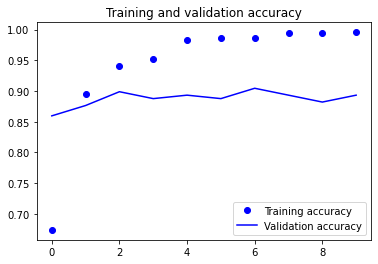

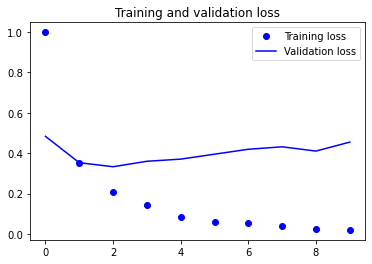

In [85]:
#Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss =history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

<ipython-input-52-352507b3f73f>:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


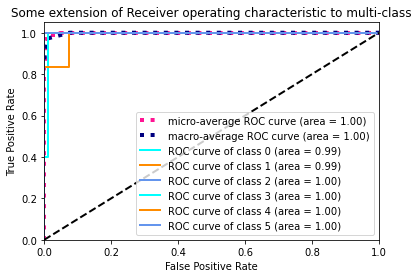

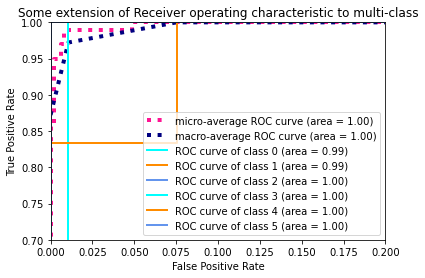

In [53]:
plot_multi_class_roc_auc_curves(nb_classes=6,
                                y_true=y_val_enc,
                                y_pred_score=y_test_pred_probs)

In [54]:
print(confusion_matrix(y_true=y_val, y_pred=y_test_pred_sdg))

[[ 5  0  0  0  0  0]
 [ 1  3  0  0  1  1]
 [ 0  0 23  0  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0  1]]


In [55]:
from typing import List, Tuple

def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [56]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_binarize = lb.fit_transform(y_val_enc)

In [57]:
y_test_transformed = lb.inverse_transform(y_val_enc)
y_test_transformed

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
 

In [58]:
import matplotlib.pyplot as plt
from typing import List, Tuple

def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

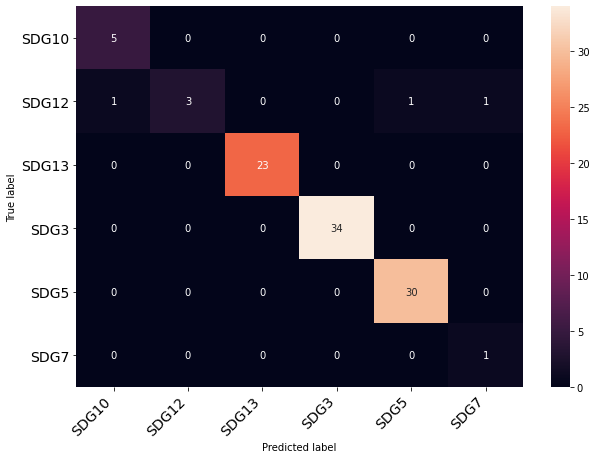

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
SDG10,5,0,0,0,0,0
SDG12,1,3,0,0,1,1
SDG13,0,0,23,0,0,0
SDG3,0,0,0,34,0,0
SDG5,0,0,0,0,30,0
SDG7,0,0,0,0,0,1


In [59]:
import seaborn as sns

print_confusion_matrix(y_true=np.argmax(y_test_transformed,axis = 1),
                           y_pred=y_test_preds,
                           class_names=['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'])

In [60]:
# Predicting a single abstract

input_abstract = """
This paper presents a global scale assessment of the impact of climate change on water scarcity.
Patterns of climate change from 21 Global Climate Models (GCMs) under four SRES scenarios are applied to a global hydrological model to estimate water resources across 1339 watersheds.
The Water Crowding Index (WCI) and the Water Stress Index (WSI) are used to calculate exposure to increases and decreases in global water scarcity due to climate change.
1.6 (WCI) and 2.4 (WSI) billion people are estimated to be currently living within watersheds exposed to water scarcity.
Using the WCI, by 2050 under the A1B scenario, 0.5 to 3.1 billion people are exposed to an increase in water scarcity due to climate change (range across 21 GCMs).
This represents a higher upper-estimate than previous assessments because scenarios are constructed from a wider range of GCMs.
A substantial proportion of the uncertainty in the global-scale effect of climate change on water scarcity is due to uncertainty in the estimates for South Asia and East Asia.
Sensitivity to the WCI and WSI thresholds that define water scarcity can be comparable to the sensitivity to climate change pattern.
More of the world will see an increase in exposure to water scarcity than a decrease due to climate change but this is not consistent across all climate change patterns.
Additionally, investigation of the effects of a set of prescribed global mean temperature change scenarios show rapid increases in water scarcity due to climate change across many regions of the globe, up to 2 °C, followed by stabilisation to 4 °C.
"""

# vectorizing titles with Count Vectorizer
abstract_vect = counter_vectorizer.transform([input_abstract])

print(abstract_vect.shape, end='\n\n')

abstract_pred = model.predict(abstract_vect)

print('Probabilities', end='\n\n')
print(abstract_pred, end='\n\n')

abstract_pred_hot = get_one_hot_predictions(abstract_pred)

print('Probabilities One Hot Vector', end='\n\n')
print(abstract_pred_hot, end='\n\n')

print('SDG Prediction:', end='\n\n')
print(y_enc.inverse_transform(abstract_pred_hot)[0][0])

(1, 300)

Probabilities

[[7.9516349e-10 7.4740927e-07 9.9999928e-01 2.7511252e-11 3.1851400e-11
  2.6017478e-08]]

Probabilities One Hot Vector

[[0. 0. 1. 0. 0. 0.]]

SDG Prediction:

SDG13


In [61]:
import os
import tempfile
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

title_save_path = os.path.join(tmpdir, "MLP_abstract_model_weights")
tf.saved_model.save(model, title_save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\arisp\AppData\Local\Temp\tmp3zhboudb\MLP_abstract_model_weights\assets
